# Impact of adding GME with GME_EFFICIENCY = 1.0 

Gustavo Marques (gmarques@ucar.edu)

Last update: 03/27/2020

### Experiments 
* G25: forced run, MEKE+GEOMETRIC (MEKE_GEOM_ALPHA = 0.08)
* G32: forced run, MEKE+GEOMETRIC (MEKE_GEOM_ALPHA = 0.08) + GME (GME_EFFICIENCY = 1)

### Time averages:
Run for 58 years, time averages over last 30 years

# Globally-averaged ocean properties

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
path = '/glade/scratch/gmarques/'
exps = ['g.c2b6.GJRA.TL319_t061.long_JRA_mct.025',\
        'g.c2b6.GJRA.TL319_t061.long_JRA_mct.032']
labels = ['G25', 'G32']

def get_data(full_path, variables):
  def preprocess(ds):
    ''' Return the dataset with variable'''
    return ds[variables]
  ds = xr.open_mfdataset(full_path, data_vars='minimal', \
                         coords='minimal', compat='override', preprocess=preprocess)
  return ds

import seaborn, matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [3]:
# load pre-difined masks
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.m6plot import ztplot, polarplot, xyplot, xycompare
import cartopy.crs as ccrs
import cartopy.feature
grd = MOM6grid('/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.002/run/g.c2b6.GJRA.TL319_t061.long_JRA_mct.002.mom6.static.nc')
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True)

Basemap module not found. Some regional plots may not function properly
MOM6 grid successfully loaded... 

11.16427964664149 64.78854837178643 [391, 434]


/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/run/*mom6.hm_*.nc
/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.032/run/*mom6.hm_*.nc


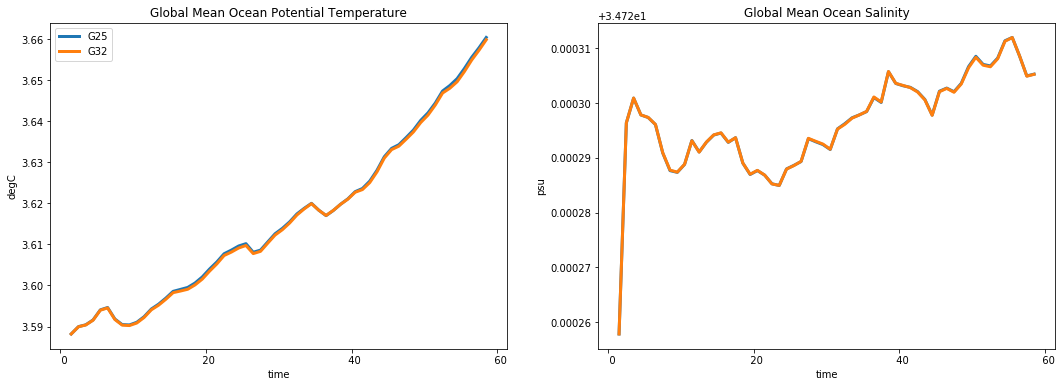

In [5]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variables = ['thetaoga', 'soga']
for i in range(len(exps)):
  tmp = path+exps[i]+'/run/*mom6.hm_*.nc'
  print(tmp)
  ds = get_data(tmp,variables)
  ds1 = ds.sel(time=slice('0001-01-01', '0059-01-01'))
  ds1['thetaoga'].plot(ax=ax[0], label=labels[i], lw=3)
  ds1['soga'].plot(ax=ax[1], lw=3)

ax[0].set_title(ds1.thetaoga.attrs['long_name']); ax[0].set_ylabel(ds1.thetaoga.attrs['units'])
ax[1].set_title(ds1.soga.attrs['long_name']); ax[1].set_ylabel(ds1.soga.attrs['units']); ax[0].legend()

/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/run/ocean.stats.nc
/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.032/run/ocean.stats.nc


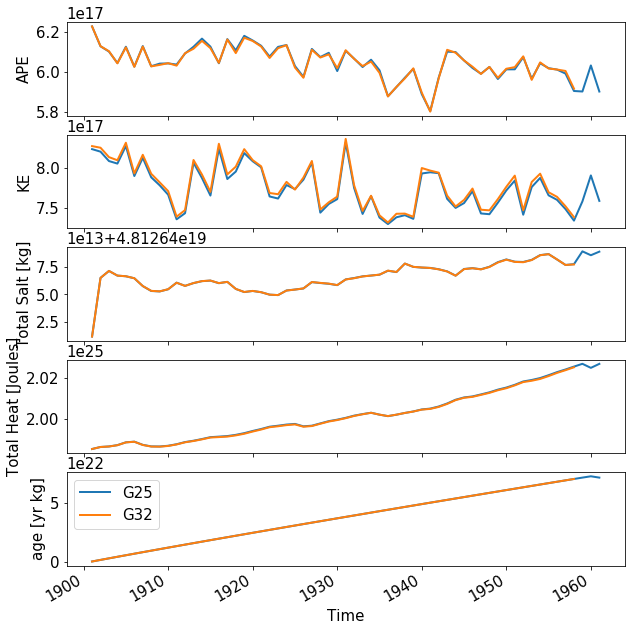

In [6]:
import pandas as pd
plt.rcParams.update({'font.size': 15})
variables = ['APE', 'KE', 'Salt', 'Heat', 'age']
fig, ax = plt.subplots(nrows=len(variables), ncols=1, figsize=(10,10), sharex=True)
for i in range(len(exps)): 
  path_to_file = path+exps[i]+'/run/ocean.stats.nc'
  print(path_to_file)
  ds = xr.open_dataset(path_to_file)
  time = pd.date_range('1900-01-01', periods=len(ds.Time), freq='D')

  ds['Time'] = time[:]  
  ds1 = ds.resample(Time="1Y", closed='left', keep_attrs=True).mean(dim='Time', keep_attrs=True)   
  ds2 = ds1.sel(Time=slice('1900-01-01', '1980-01-01'))
  for var, j in zip(variables, range(len(variables))):
    if len(ds2[var].shape) > 1:
        tmp = ds2[var].sum(axis=1)
    else:
        tmp = ds2[var]
    tmp.plot(ax=ax[j], label=labels[i], lw=2)
    ax[j].set_xlabel('')
    
ax[j].set_xlabel('Time'); ax[j].legend()

# Mixed layer depth

In [7]:
filepath = '/glade/work/gmarques/cesm/datasets/MLD/deBoyer/deBoyer_MLD_remapped_to_tx06v1.nc'
print('\n Reading climatology from: ', filepath)
mld_obs = xr.open_dataset(filepath)
months = [0,1,2]
obs_JFM = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
months = [6,7,8]
obs_JAS = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
obs_winter = obs_JAS.copy(); obs_summer = obs_JAS.copy()
j = np.abs( grd.geolat[:,0] - 0. ).argmin()
obs_winter[j::,:] = obs_JFM[j::,:]
obs_summer[0:j,:] = obs_JFM[0:j,:]

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
def add_labels(ax, nh='JFM', sh='JAS'):
    ax.plot([grd.geolon[0,0], grd.geolon[0,-1]], [0,0], 'k--', lw=0.5)
    ax.text(25, 7, nh, ha="center", va="center", size=12, bbox=bbox_props)
    ax.text(25, -7, sh, ha="center", va="center", size=12, bbox=bbox_props)


 Reading climatology from:  /glade/work/gmarques/cesm/datasets/MLD/deBoyer/deBoyer_MLD_remapped_to_tx06v1.nc


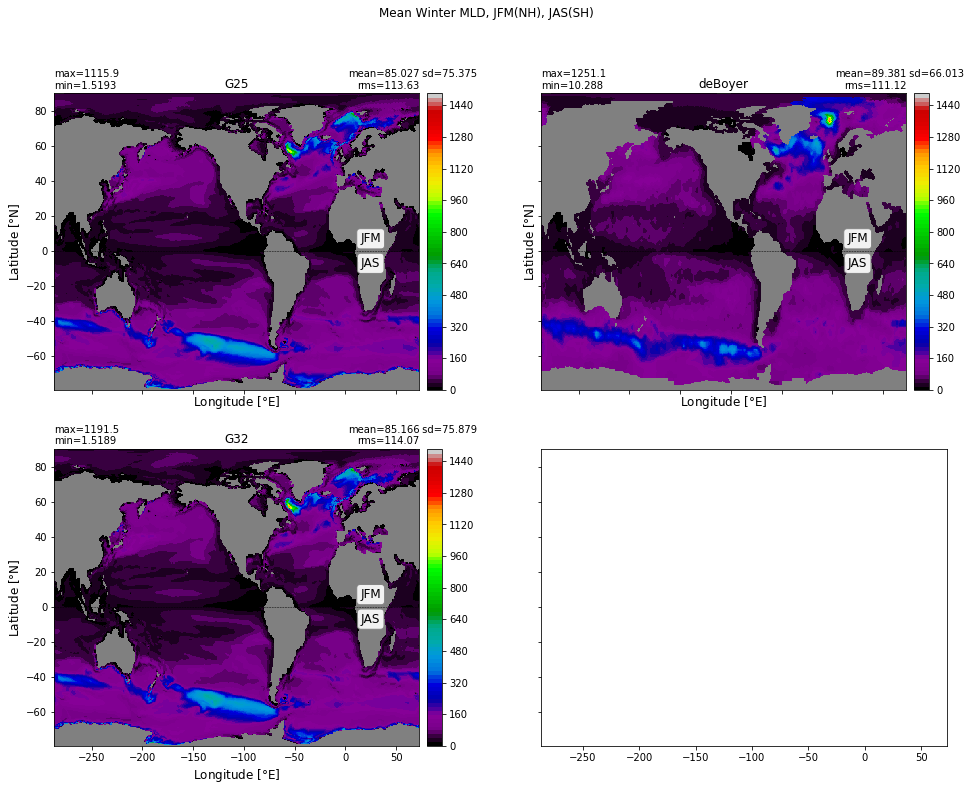

In [9]:
%matplotlib inline
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True, sharey=True)
ax1 = ax.flatten()
plt.suptitle('Mean Winter MLD, JFM(NH), JAS(SH)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_winter.nc')
  if i == 0:
   control = np.ma.masked_invalid(ds.MLD_winter.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,1500), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i])
  else:
   var = np.ma.masked_invalid(ds.MLD_winter.values) 
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i+1], clim=(0,1500),
         colormap=plt.cm.nipy_spectral, nbins=100); add_labels(ax1[i+1])

xyplot(obs_winter, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,1500), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1])

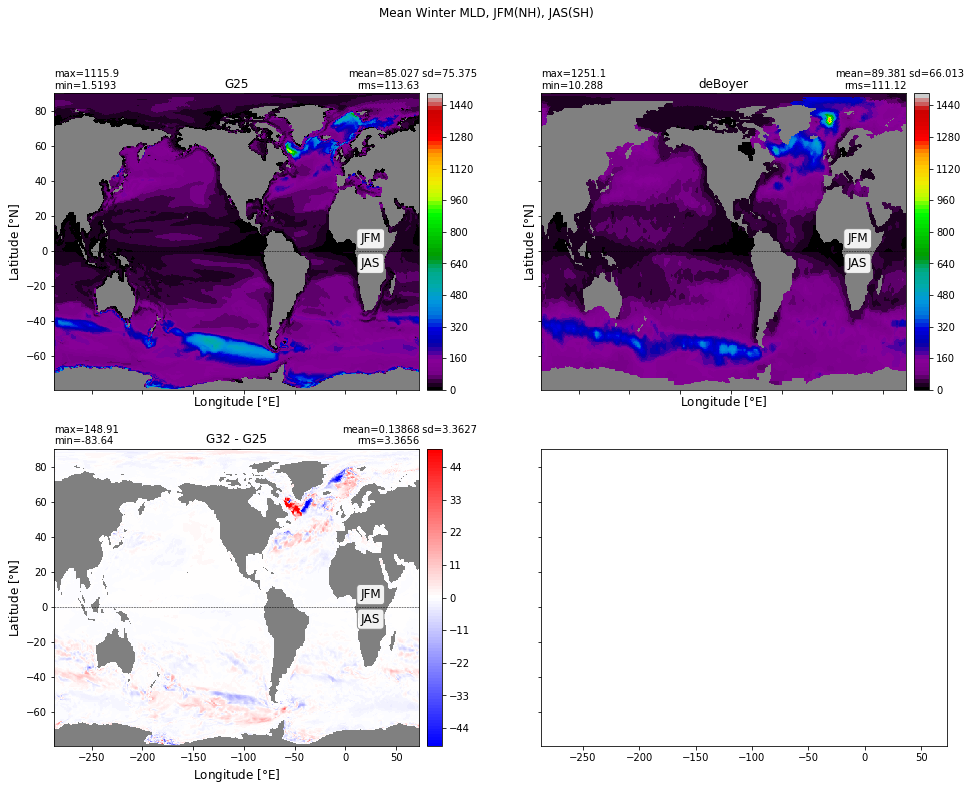

In [14]:
%matplotlib inline
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True, sharey=True)
ax1 = ax.flatten()
plt.suptitle('Mean Winter MLD, JFM(NH), JAS(SH)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_winter.nc')
  if i == 0:
   control = np.ma.masked_invalid(ds.MLD_winter.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,1500), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i])
  else:
   var = np.ma.masked_invalid(ds.MLD_winter.values) - control
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]) + ' - G25', axis=ax1[i+1], clim=(-50,50),
         colormap=plt.cm.bwr, extend='neither', centerlabels=True, nbins=100); add_labels(ax1[i+1])

xyplot(obs_winter, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,1500), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1])

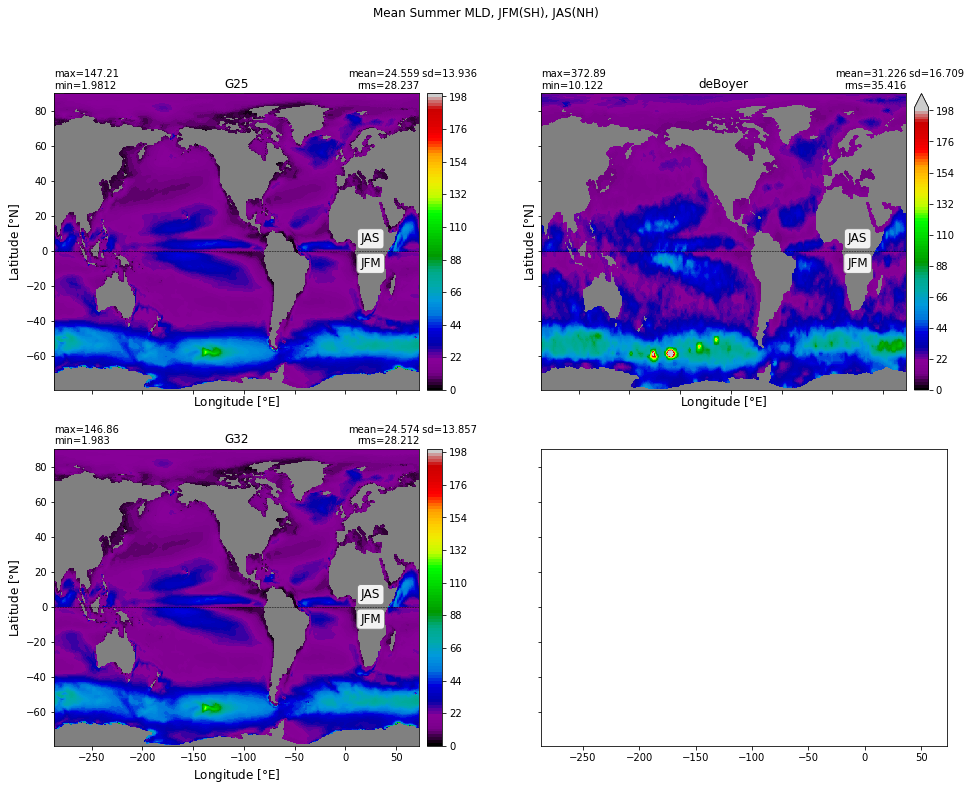

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True, sharey=True)
ax1 = ax.flatten()
plt.suptitle('Mean Summer MLD, JFM(SH), JAS(NH)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_summer.nc')
  if i == 0:
   control = np.ma.masked_invalid(ds.MLD_summer.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i], sh='JFM', nh='JAS')
  else:
   var = np.ma.masked_invalid(ds.MLD_summer.values) 
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i+1], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i+1], sh='JFM', nh='JAS')

xyplot(obs_summer, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,200), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1], sh='JFM', nh='JAS')

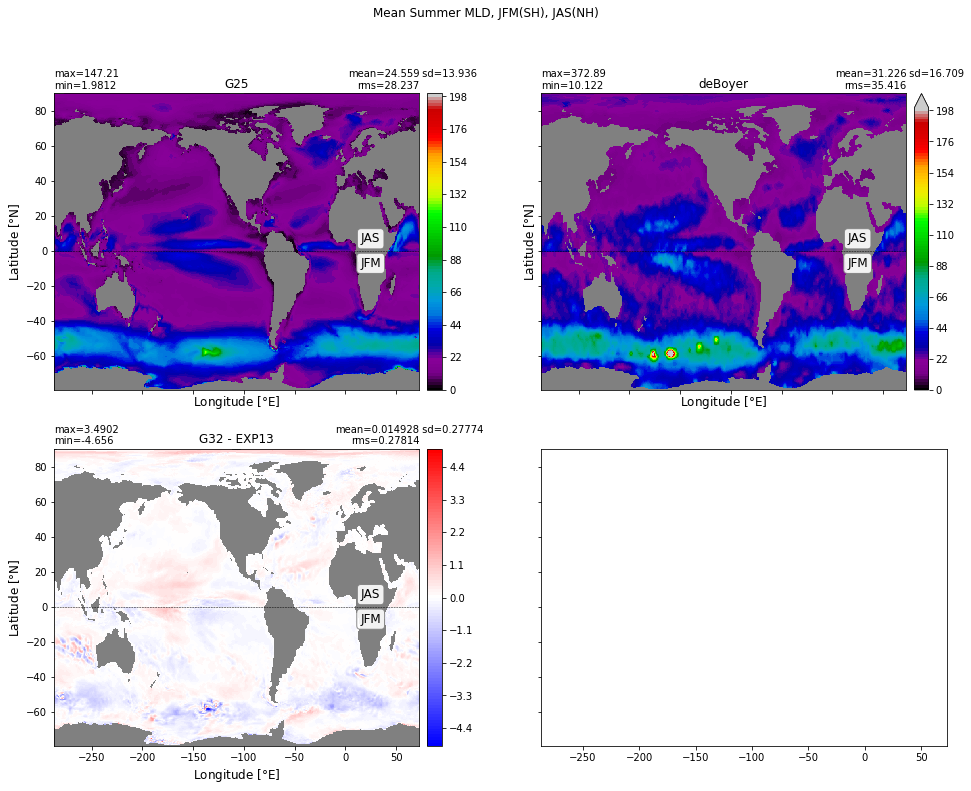

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True, sharey=True)
ax1 = ax.flatten()
plt.suptitle('Mean Summer MLD, JFM(SH), JAS(NH)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_summer.nc')
  if i == 0:
   control = np.ma.masked_invalid(ds.MLD_summer.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i], sh='JFM', nh='JAS')
  else:
   var = np.ma.masked_invalid(ds.MLD_summer.values) - control
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]) + ' - EXP13', axis=ax1[i+1], clim=(-5,5),
         colormap=plt.cm.bwr, extend='neither', centerlabels=True, nbins=100); add_labels(ax1[i+1], sh='JFM', nh='JAS')

xyplot(obs_summer, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,200), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1], sh='JFM', nh='JAS')

# Poleward Heat Transport

In [19]:
def get_heat_transport_obs():
  import netCDF4
  """Plots model vs obs poleward heat transport for the global, Pacific and Atlantic basins"""
  # Load Observations
  fObs = netCDF4.Dataset('/glade/work/gmarques/cesm/datasets/Trenberth_and_Caron_Heat_Transport.nc')
  #Trenberth and Caron
  yobs = fObs.variables['ylat'][:]
  NCEP = {}; NCEP['Global'] = fObs.variables['OTn']
  NCEP['Atlantic'] = fObs.variables['ATLn'][:]; NCEP['IndoPac'] = fObs.variables['INDPACn'][:]
  ECMWF = {}; ECMWF['Global'] = fObs.variables['OTe'][:]
  ECMWF['Atlantic'] = fObs.variables['ATLe'][:]; ECMWF['IndoPac'] = fObs.variables['INDPACe'][:]

  #G and W
  Global = {}
  Global['lat'] = np.array([-30., -19., 24., 47.])
  Global['trans'] = np.array([-0.6, -0.8, 1.8, 0.6])
  Global['err'] = np.array([0.3, 0.6, 0.3, 0.1])

  Atlantic = {}
  Atlantic['lat'] = np.array([-45., -30., -19., -11., -4.5, 7.5, 24., 47.])
  Atlantic['trans'] = np.array([0.66, 0.35, 0.77, 0.9, 1., 1.26, 1.27, 0.6])
  Atlantic['err'] = np.array([0.12, 0.15, 0.2, 0.4, 0.55, 0.31, 0.15, 0.09])

  IndoPac = {}
  IndoPac['lat'] = np.array([-30., -18., 24., 47.])
  IndoPac['trans'] = np.array([-0.9, -1.6, 0.52, 0.])
  IndoPac['err'] = np.array([0.3, 0.6, 0.2, 0.05,])

  GandW = {}
  GandW['Global'] = Global
  GandW['Atlantic'] = Atlantic
  GandW['IndoPac'] = IndoPac
  return NCEP, ECMWF, GandW, yobs

NCEP, ECMWF, GandW, yobs = get_heat_transport_obs()
from mom6_tools.poleward_heat_transport import annotateObs, plotGandW, plotHeatTrans, heatTrans

In [20]:
def get_adv_diff(ds):
  # create a ndarray subclass
  class C(np.ndarray): pass

  varName = 'T_ady_2d'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds[varName].values)
    tmp = tmp[:].filled(0.)
    advective = tmp.view(C)
    advective.units = 'W'
  else:
    raise Exception('Could not find "T_ady_2d"')

  varName = 'T_diffy_2d'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds[varName].values)
    tmp = tmp[:].filled(0.)
    diffusive = tmp.view(C)
    diffusive.units = 'W'
  else:
    diffusive = None
    warnings.warn('Diffusive temperature term not found. This will result in an underestimation of the heat transport.')

  varName = 'T_lbm_diffy'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds_sel[varName].sum('z_l').values)
    tmp = tmp[:].filled(0.)
    diffusive = diffusive + tmp.view(C)
  else:
    warnings.warn('Lateral boundary mixing term not found. This will result in an underestimation of the heat transport.')
    
  return advective, diffusive

<center> <font size="4">Global Heat Transport</font>

(-2.5, 2.5)

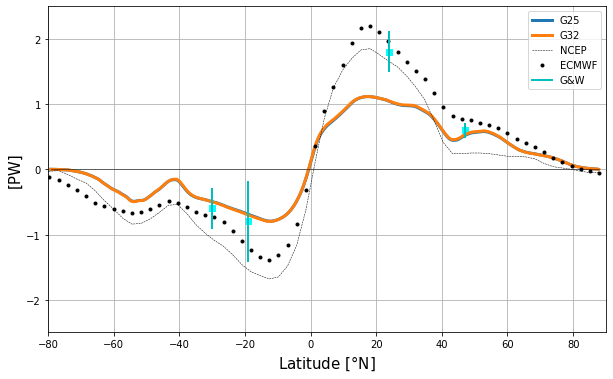

In [21]:
# Global Heat Transport
plt.figure(figsize=(10,6))
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_heat_transport.nc')
  adv, diff = get_adv_diff(ds);   HT = heatTrans(adv,diff); y = ds.yq;   plt.plot(y, HT, linewidth=3,label=labels[i]);     
plt.xlim(-80,90); plt.ylim(-2.5,3.0); plt.grid(True); plt.plot(y, y*0., 'k', linewidth=0.5); plt.plot(yobs,NCEP['Global'],'k--',linewidth=0.5,label='NCEP'); 
plt.plot(yobs,ECMWF['Global'],'k.',linewidth=0.5,label='ECMWF'); plotGandW(GandW['Global']['lat'],GandW['Global']['trans'],GandW['Global']['err']); plt.xlabel(r'Latitude [$\degree$N]',fontsize=15)
plt.ylabel('[PW]',fontsize=15); plt.legend(loc=0,fontsize=10)
plt.ylim(-2.5,2.5)

In [22]:
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth)

11.16427964664149 64.78854837178643 [391, 434]


<center> <font size="4">Atlantic Heat Transport</font>

(0, 1.8)

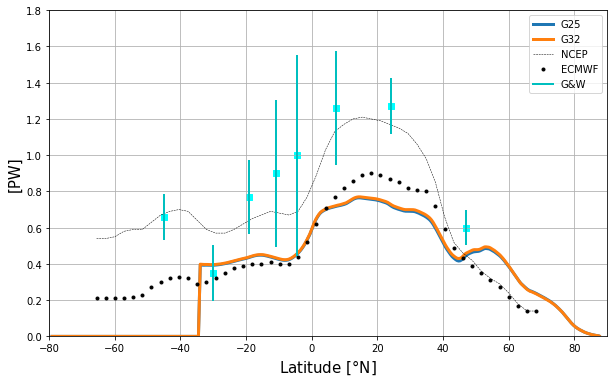

In [23]:
# Atlantic Heat Transport
m = 0*basin_code; m[(basin_code==2) | (basin_code==4) | (basin_code==6) | (basin_code==7) | (basin_code==8)] = 1
plt.figure(figsize=(10,6))
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_heat_transport.nc')
  adv, diff = get_adv_diff(ds);   HT = heatTrans(adv,diff, vmask=m*np.roll(m,-1,axis=-2)); y = ds.yq;   plt.plot(y, HT, linewidth=3,label=labels[i]);     
plt.xlim(-80,90); plt.ylim(-0.1,2.0); plt.grid(True); plt.plot(y, y*0., 'k', linewidth=0.5); plt.plot(yobs,NCEP['Atlantic'],'k--',linewidth=0.5,label='NCEP'); 
plt.plot(yobs,ECMWF['Atlantic'],'k.',linewidth=0.5,label='ECMWF'); plotGandW(GandW['Atlantic']['lat'],GandW['Atlantic']['trans'],GandW['Atlantic']['err']); plt.xlabel(r'Latitude [$\degree$N]',fontsize=15)
plt.ylabel('[PW]',fontsize=15); plt.legend(loc=0,fontsize=10)
plt.ylim(0,1.8)

# Meridional Overturning Circulation

<center> <font size="4">Global</font>
 </center>
<table><tr><td><img   src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/PNG/MOC/g.c2b6.GJRA.TL319_t061.long_JRA_mct.025_MOC_global.png'></td>
             <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.032/PNG/MOC/g.c2b6.GJRA.TL319_t061.long_JRA_mct.032_MOC_global.png'></td></tr>
</table>

<center> <font size="4">Atlantic</font></center>
<table><tr><td><img   src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/PNG/MOC/g.c2b6.GJRA.TL319_t061.long_JRA_mct.025_MOC_Atlantic.png'></td>
             <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.032/PNG/MOC/g.c2b6.GJRA.TL319_t061.long_JRA_mct.032_MOC_Atlantic.png'></td></tr>
</table>

<center> <font size="4">AMOC time series @ 26N and 45N</font>

Text(0.5, 1.0, 'AMOC time series @ 45N')

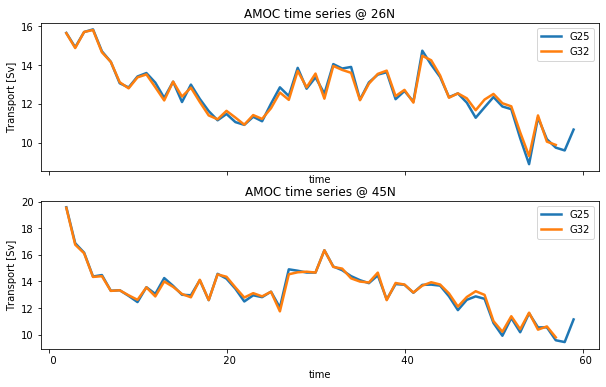

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)
for i in range(len(exps)):
  ds1 = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MOC_26N_time_series.nc')
  ds1.__xarray_dataarray_variable__.plot(ax=ax[0], label=labels[i], lw=2.5)
  ds2 = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MOC_45N_time_series.nc')
  ds2.__xarray_dataarray_variable__.plot(ax=ax[1], label=labels[i], lw=2.5)

ax[0].set_ylabel('Transport [Sv]'); ax[0].legend(); ax[0].set_title('AMOC time series @ 26N')
ax[1].set_ylabel('Transport [Sv]'); ax[1].legend(); ax[1].set_title('AMOC time series @ 45N')

# Transports

In [35]:
#i=0
#ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_section_transports.nc')
#ds.sections

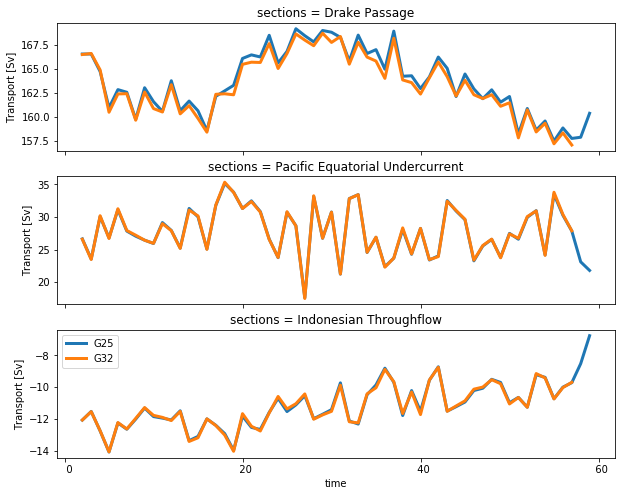

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,8), sharex=True)
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_section_transports.nc')
  ds.transport.sel(sections='Drake Passage').plot(ax=ax[0], label=labels[i], lw=3)
  ds.transport.sel(sections='Pacific Equatorial Undercurrent').plot(ax=ax[1], label=labels[i], lw=3)
  ds.transport.sel(sections='Indonesian Throughflow').plot(ax=ax[2], label=labels[i], lw=3)
  
ax[0].set_ylabel('Transport [Sv]'); ax[0].set_xlabel('')
ax[1].set_ylabel('Transport [Sv]'); ax[1].set_xlabel('')
ax[2].set_ylabel('Transport [Sv]'); ax[2].legend()

# T/S bias at selected vertical levels

In [4]:
# load PHC2 data
phc_path = '/glade/p/cesm/omwg/obs_data/phc/'
phc_temp = xr.open_mfdataset(phc_path+'PHC2_TEMP_tx0.66v1_34lev_ann_avg.nc', 
                             decode_coords=False, decode_times=False)
phc_salt = xr.open_mfdataset(phc_path+'PHC2_SALT_tx0.66v1_34lev_ann_avg.nc', 
                             decode_coords=False, decode_times=False)

## Temperature

Temperature bias [C] at level 0 or depth = 2.5 m


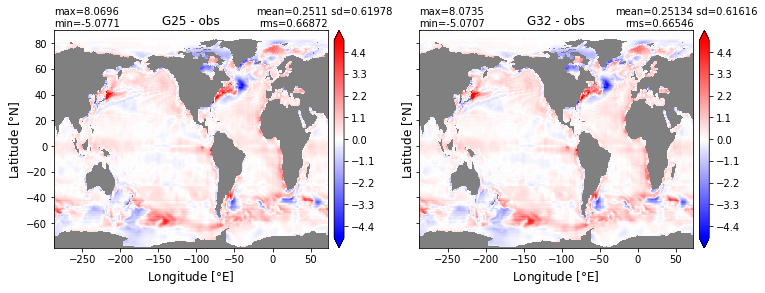

In [5]:
%matplotlib inline
# change k indice to see bias at other depths
k=0
temp_obs = np.ma.masked_invalid(phc_temp['TEMP'][k,:].values)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True)
print('Temperature bias [C] at level {} or depth = {} m'.format(k, phc_temp.depth[k].values))
ax1 = ax.flatten()
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_thetao_time_mean.nc')
  model = np.ma.masked_invalid(ds.thetao[k,:].values)
  xyplot(model-temp_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]+' - obs'), axis=ax1[i], 
         clim=(-5,5), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

Temperature bias [C] at level 10 or depth = 250.0 m


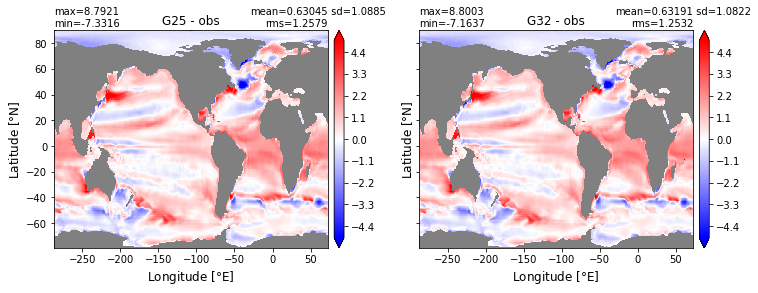

In [7]:
k=10
temp_obs = np.ma.masked_invalid(phc_temp['TEMP'][k,:].values)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True)
print('Temperature bias [C] at level {} or depth = {} m'.format(k, phc_temp.depth[k].values))
ax1 = ax.flatten()
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_thetao_time_mean.nc')
  model = np.ma.masked_invalid(ds.thetao[k,:].values)
  xyplot(model-temp_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]+' - obs'), axis=ax1[i], 
         clim=(-5,5), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

Temperature bias [C] at level 20 or depth = 1200.0 m


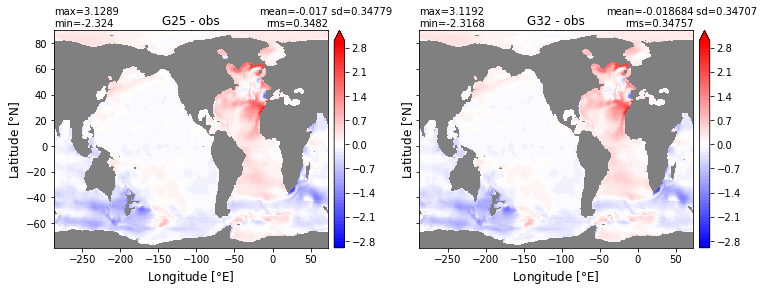

In [8]:
k=20
temp_obs = np.ma.masked_invalid(phc_temp['TEMP'][k,:].values)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True)
print('Temperature bias [C] at level {} or depth = {} m'.format(k, phc_temp.depth[k].values))
ax1 = ax.flatten()
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_thetao_time_mean.nc')
  model = np.ma.masked_invalid(ds.thetao[k,:].values)
  xyplot(model-temp_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]+' - obs'), axis=ax1[i], 
         clim=(-3,3), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

## Salinity

Salinity bias [psu] at level 0 or depth = 2.5 m


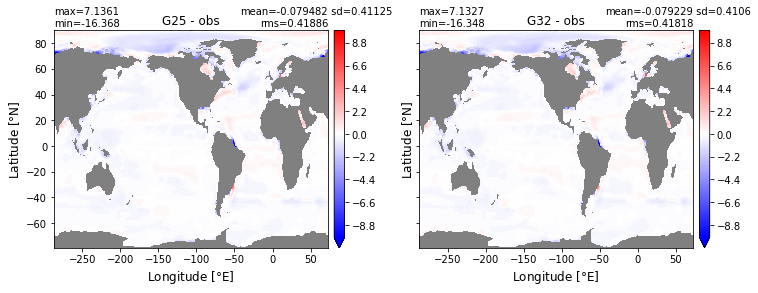

In [9]:
%matplotlib inline
# change k indice to see bias at other depths
k=0
salt_obs = np.ma.masked_invalid(phc_salt['SALT'][k,:].values)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True)
print('Salinity bias [psu] at level {} or depth = {} m'.format(k, phc_temp.depth[k].values))
ax1 = ax.flatten()
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_so_time_mean.nc')
  model = np.ma.masked_invalid(ds.so[k,:].values)
  xyplot(model-salt_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]+' - obs'), axis=ax1[i], 
         clim=(-10,10), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

Salinity bias [psu] at level 10 or depth = 250.0 m


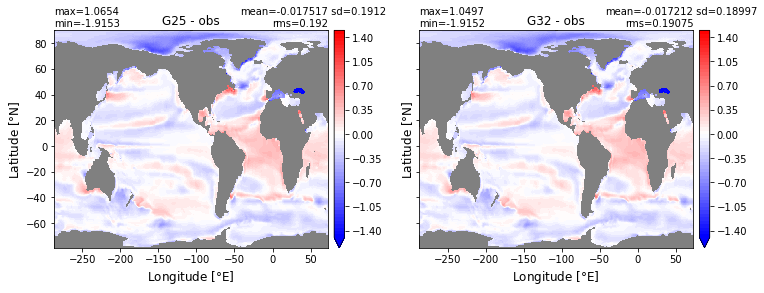

In [10]:
k=10
salt_obs = np.ma.masked_invalid(phc_salt['SALT'][k,:].values)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True)
print('Salinity bias [psu] at level {} or depth = {} m'.format(k, phc_temp.depth[k].values))
ax1 = ax.flatten()
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_so_time_mean.nc')
  model = np.ma.masked_invalid(ds.so[k,:].values)
  xyplot(model-salt_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]+' - obs'), axis=ax1[i], 
         clim=(-1.5,1.5), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

Salinity bias [psu] at level 20 or depth = 1200.0 m


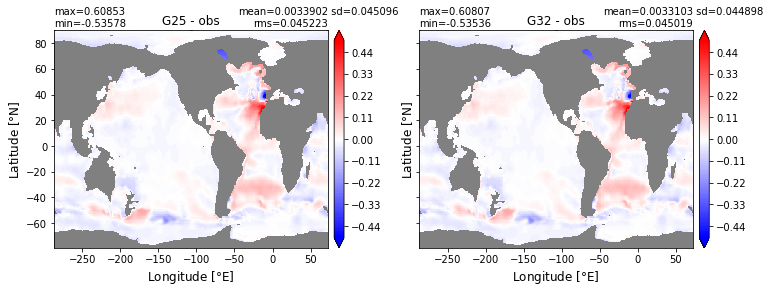

In [11]:
k=20
salt_obs = np.ma.masked_invalid(phc_salt['SALT'][k,:].values)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True)
print('Salinity bias [psu] at level {} or depth = {} m'.format(k, phc_temp.depth[k].values))
ax1 = ax.flatten()
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_so_time_mean.nc')
  model = np.ma.masked_invalid(ds.so[k,:].values)
  xyplot(model-salt_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]+' - obs'), axis=ax1[i], 
         clim=(-.5,.5), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

# SSH Comparison

## Mean sea level

In [12]:
avisofile = '/glade/work/gmarques/cesm/datasets/Aviso/mean_ssh_yearly_climatology_remaped_to_tx0.6v1.nc'
aviso = xr.open_mfdataset(avisofile,decode_times=False)
adt = np.ma.masked_invalid(aviso['adt'].values)

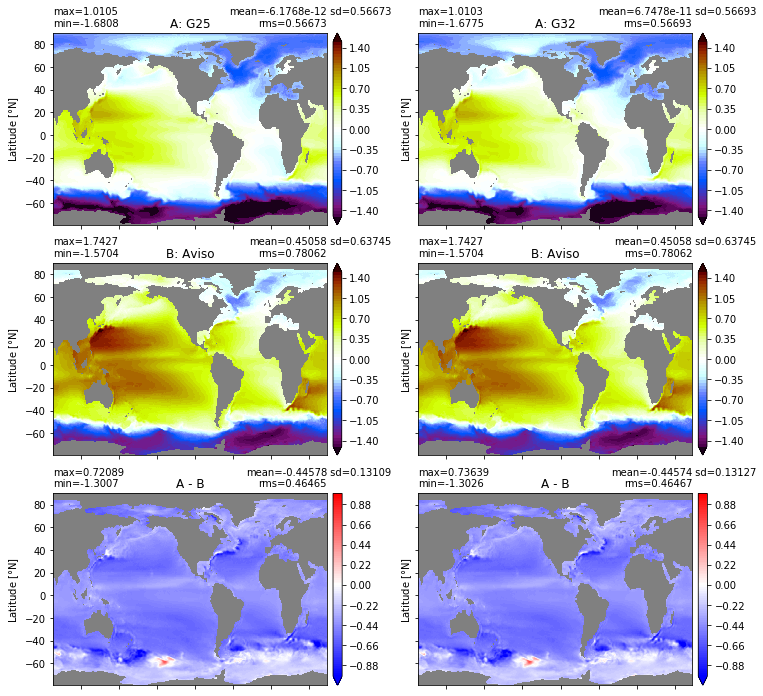

In [13]:
%matplotlib inline
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12), sharex=True, sharey=True)
ax1 = [[ax[0,0], ax[1,0], ax[2,0]], [ax[0,1], ax[1,1], ax[2,1]]]
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_mean_sea_level.nc')
  model = np.ma.masked_invalid(ds['mean_sl'].values)
  xycompare(model, adt, grd.geolon, grd.geolat, grd.area_t, title1=str(labels[i]),
            title2='Aviso', axis=ax1[i], clim=(-1.5,1.5), nbins=100, dlim=(-1,1),
            dcolormap=plt.cm.bwr)

## Mean sea level anomaly

In [14]:
filepath = '/glade/work/gmarques/cesm/datasets/Aviso/rms_sla_climatology_remaped_to_tx0.6v1.nc'
aviso = xr.open_mfdataset(filepath,decode_times=False)
rms_sla = np.ma.masked_invalid(aviso['rms_sla'].values)

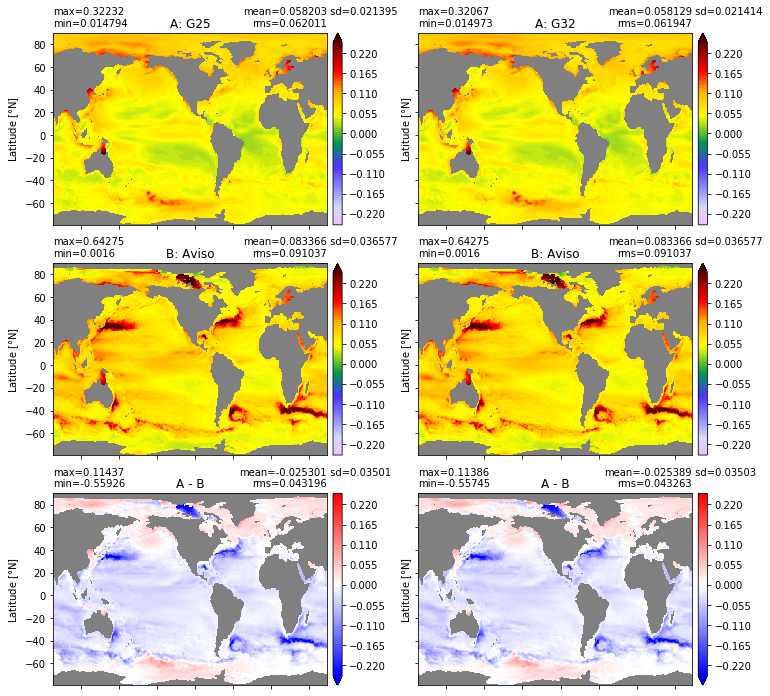

In [15]:
%matplotlib inline
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12), sharex=True, sharey=True)
ax1 = [[ax[0,0], ax[1,0], ax[2,0]], [ax[0,1], ax[1,1], ax[2,1]]]
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_RMS_SLA.nc')
  model = np.ma.masked_invalid(ds['rms_sla'].values)
  xycompare(model, rms_sla, grd.geolon, grd.geolat, grd.area_t, title1=str(labels[i]),
            title2='Aviso', axis=ax1[i], clim=(-0.25,0.25), nbins=100, dlim=(-0.25,0.25),
            dcolormap=plt.cm.bwr)

# Equatorial plots

## Temperature

<center> <font size="4">Equatorial_Global_temperature</font></center>
<table><tr>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/PNG/Equatorial/g.c2b6.GJRA.TL319_t061.long_JRA_mct.025_Equatorial_Global_temperature.png'></td>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.032/PNG/Equatorial/g.c2b6.GJRA.TL319_t061.long_JRA_mct.032_Equatorial_Global_temperature.png'></td>
    </tr>          
</table>

## Salinity

<center> <font size="4">Equatorial_Global_salinity</font></center>
<table><tr><td>
    <img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/PNG/Equatorial/g.c2b6.GJRA.TL319_t061.long_JRA_mct.025_Equatorial_Global_salinity.png'></td>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.032/PNG/Equatorial/g.c2b6.GJRA.TL319_t061.long_JRA_mct.032_Equatorial_Global_salinity.png'></td>
    </tr>
</table>

## Undercurrent

<center> <font size="4">Equatorial_Pacific_uo</font></center>
<table><tr><td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/PNG/Equatorial/g.c2b6.GJRA.TL319_t061.long_JRA_mct.025_Equatorial_Pacific_uo.png'></td></tr>
             <tr><td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.032/PNG/Equatorial/g.c2b6.GJRA.TL319_t061.long_JRA_mct.032_Equatorial_Pacific_uo.png'></td></tr> 
</table>

# Horizontal Mean bias (w.r.t. obs) versus time

In [19]:
#i=0
#ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
#ds.region

## Global

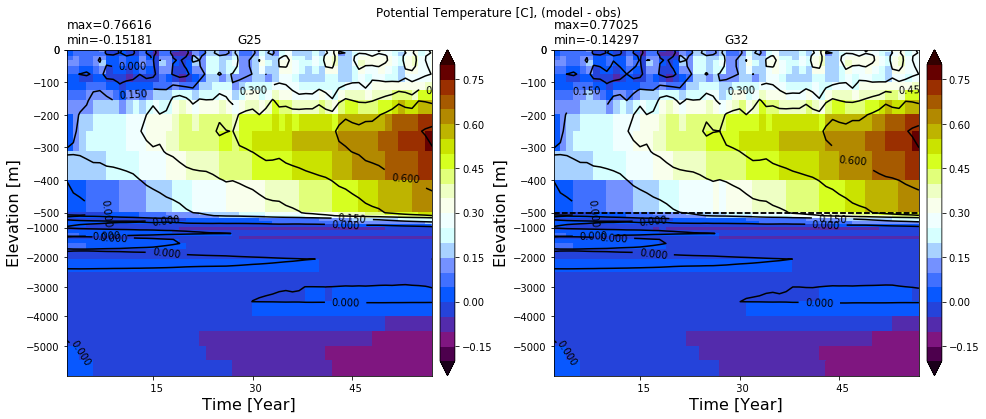

In [32]:
# %matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
plt.suptitle('Potential Temperature [C], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='Global').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-0.2, 0.8)); 

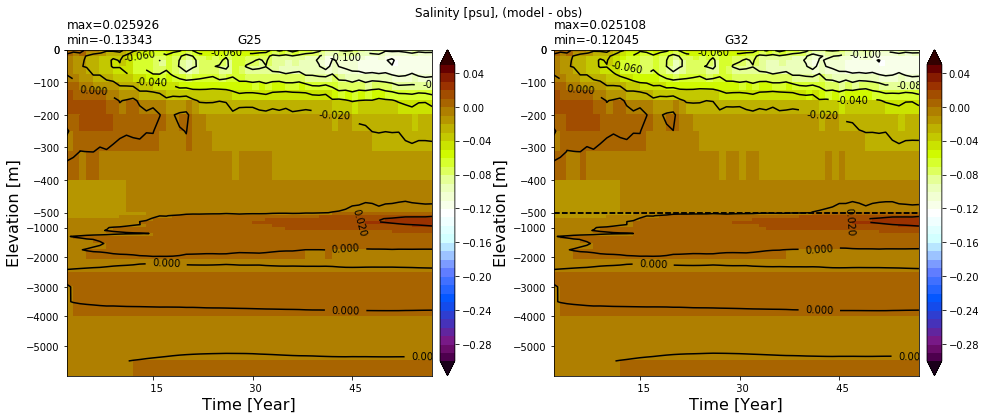

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
plt.suptitle('Salinity [psu], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_salt_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='Global').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-0.3, 0.05)); 

## Atlantic

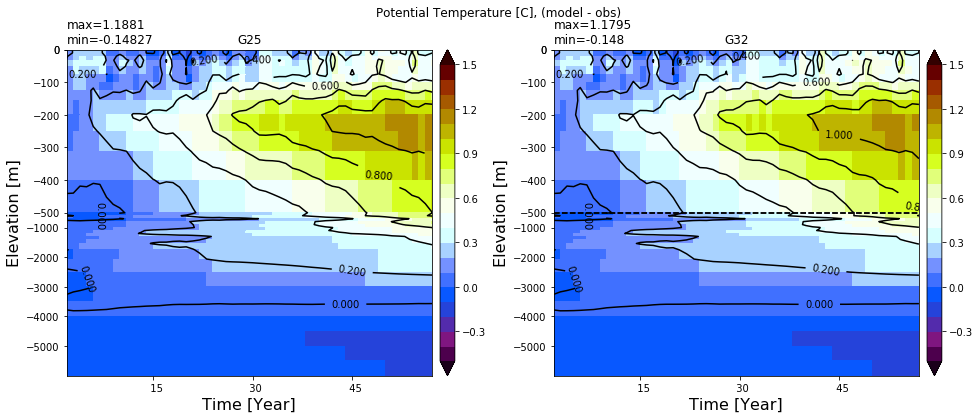

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
plt.suptitle('Potential Temperature [C], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='AtlanticOcean').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-0.5, 1.5)); 

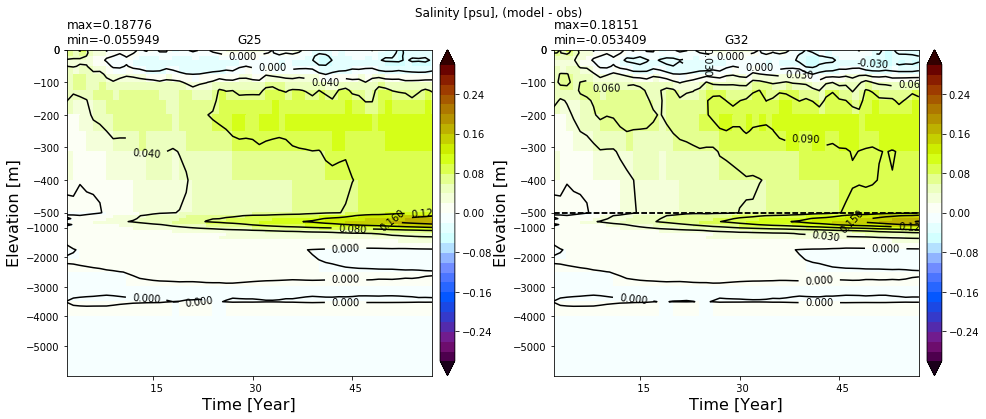

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
plt.suptitle('Salinity [psu], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_salt_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='AtlanticOcean').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-0.3, 0.3)); 

## Pacific

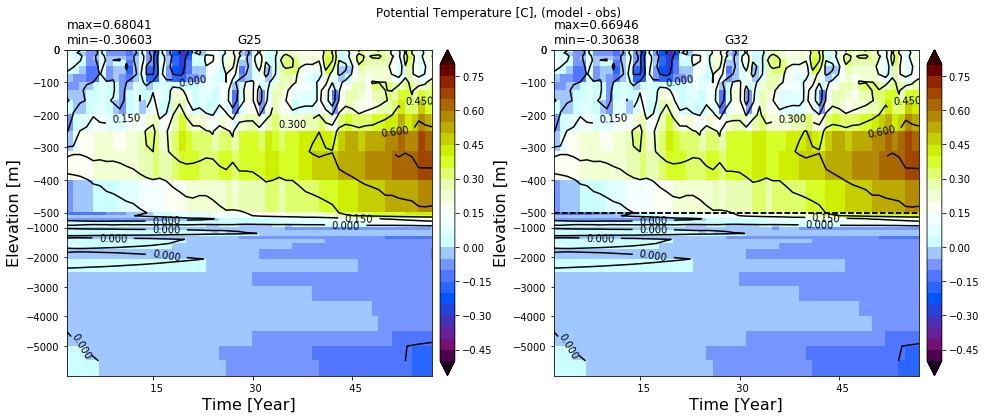

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
plt.suptitle('Potential Temperature [C], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='PacificOcean').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-0.5, 0.8)); 

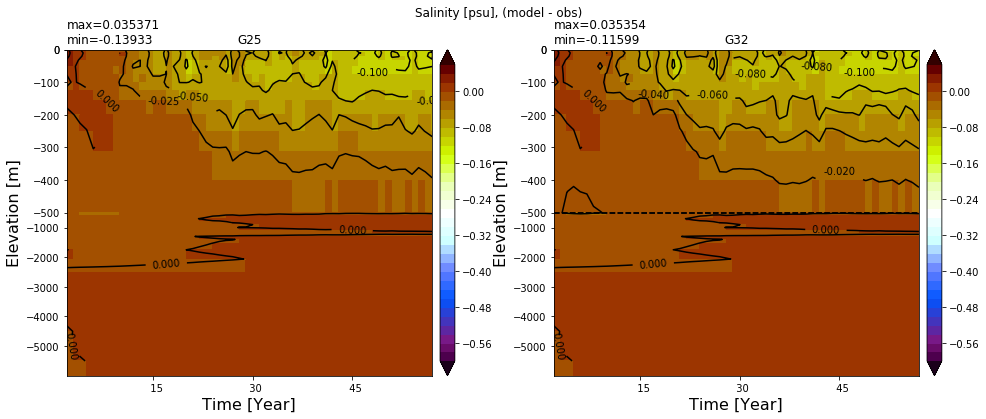

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
plt.suptitle('Salinity [psu], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_salt_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='PacificOcean').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-0.6, 0.05)); 

## Southern Ocean

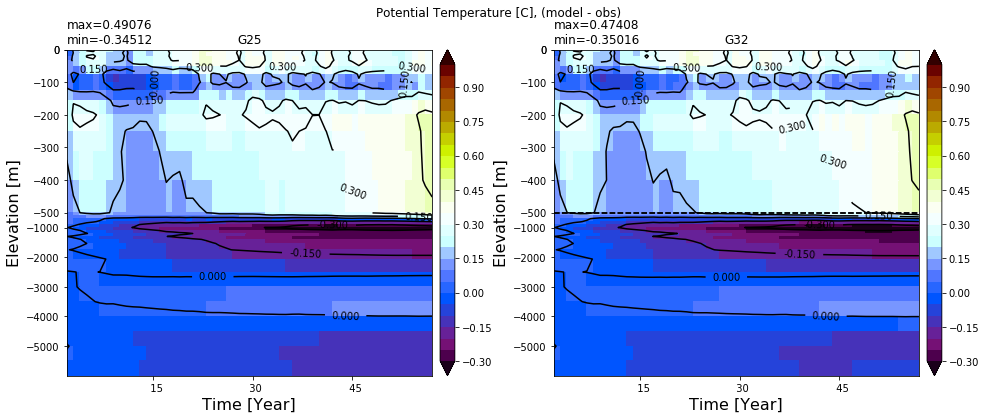

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
plt.suptitle('Potential Temperature [C], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='SouthernOcean').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-.3, 1.)); 

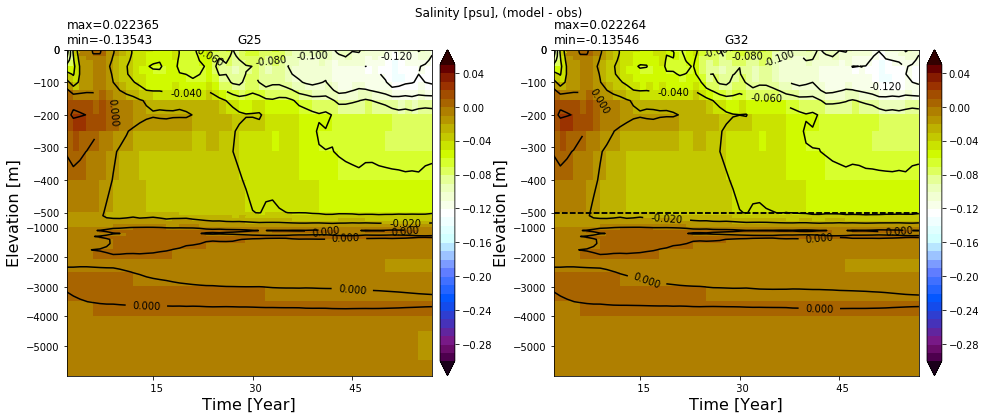

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
plt.suptitle('Salinity [psu], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_salt_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='SouthernOcean').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-0.3, 0.05)); 

## Arctic

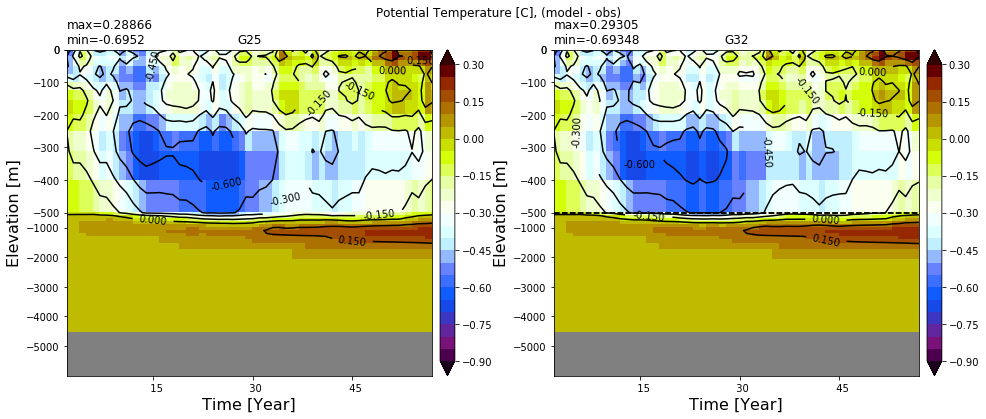

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
plt.suptitle('Potential Temperature [C], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='Arctic').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-.9, .3)); 

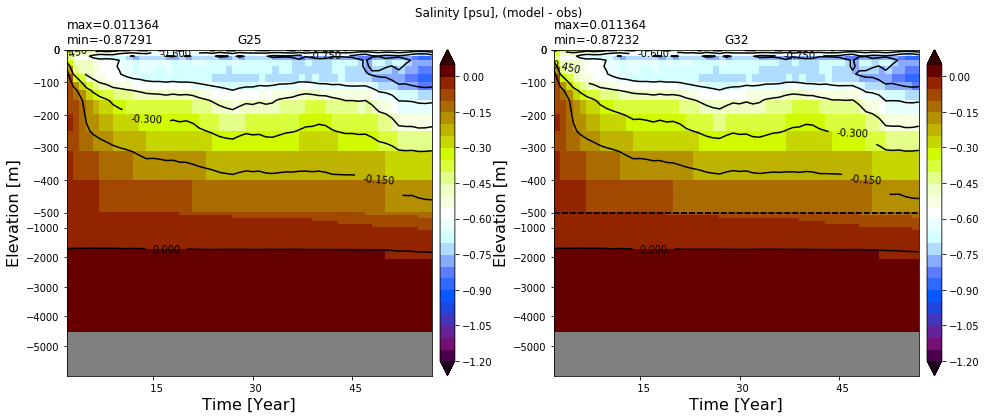

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
plt.suptitle('Salinity [psu], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_salt_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='Arctic').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-1.2, 0.02)); 

# Mixing coefficients

In [16]:
def get_data_sf(full_path):
  ds = xr.open_dataset(full_path)
  return ds
variables = ['diftrblo', 'difmxylo' ,'difmxybo', 'diftrelo']

## GM (KHTH)

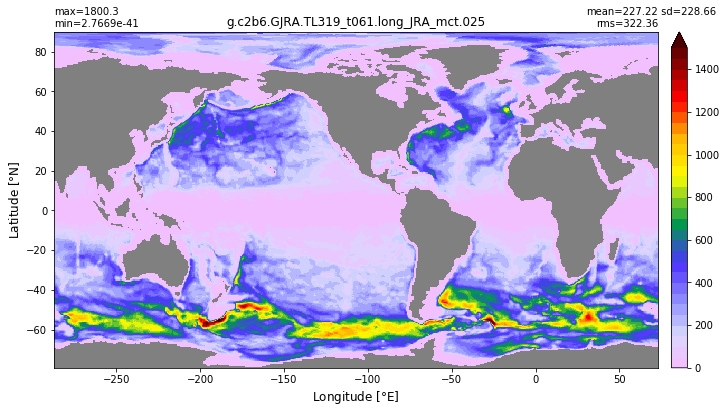

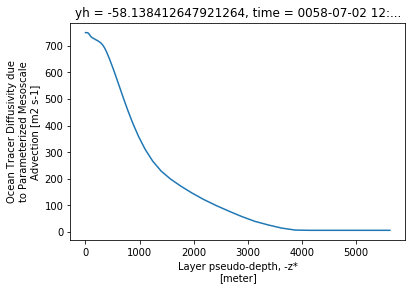

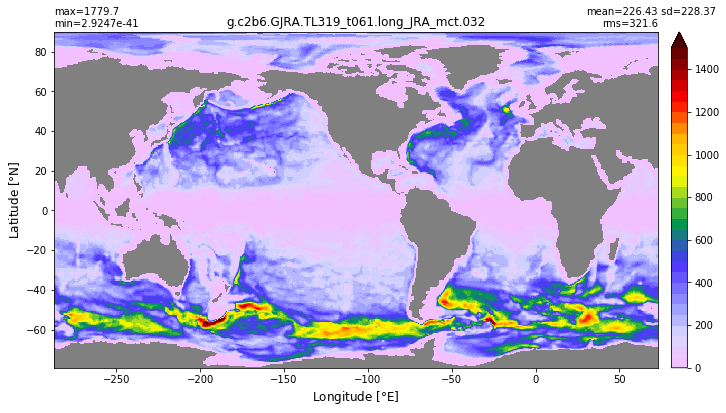

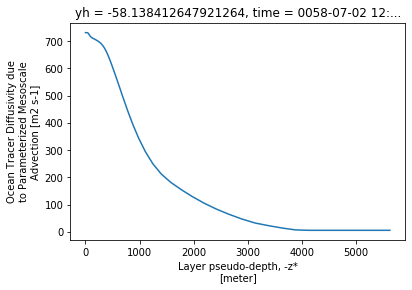

In [43]:
# GM coefficient
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0058.nc')
  xyplot(np.ma.masked_invalid(ds[variables[0]][0,0,:].values), grd.geolon, grd.geolat, area=grd.area_t, 
         clim=(0,1500), title=str(exps[exp]))
  f, ax = plt.subplots(1,1)
  ds[variables[0]][0,:,j,i].plot(ax=ax)


## Laplacian viscosity

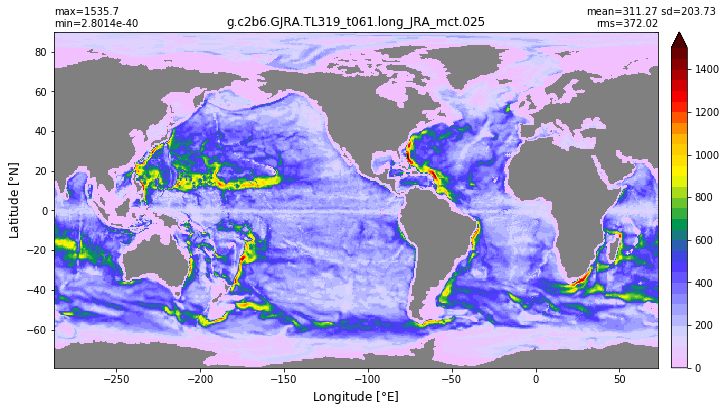

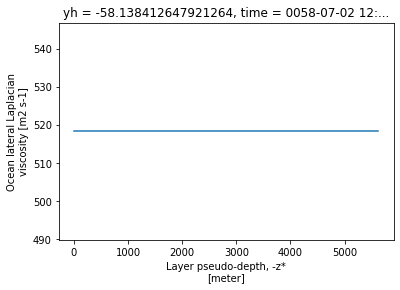

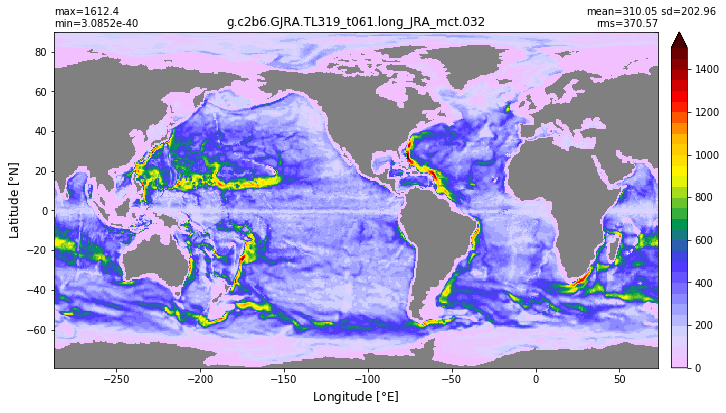

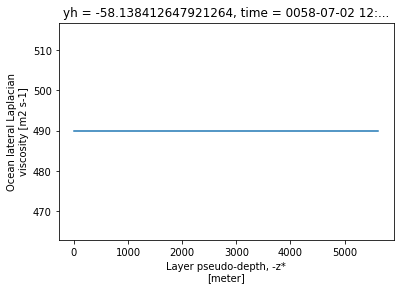

In [44]:
# Laplacian visc
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0058.nc')
  xyplot(np.ma.masked_invalid(ds[variables[1]][0,0,:].values), grd.geolon, grd.geolat, area=grd.area_t, clim=(0,1500), title=str(exps[exp]))
  f, ax = plt.subplots(1,1)
  ds[variables[1]][0,:,j,i].plot(ax=ax)

## Biharmonic viscosity

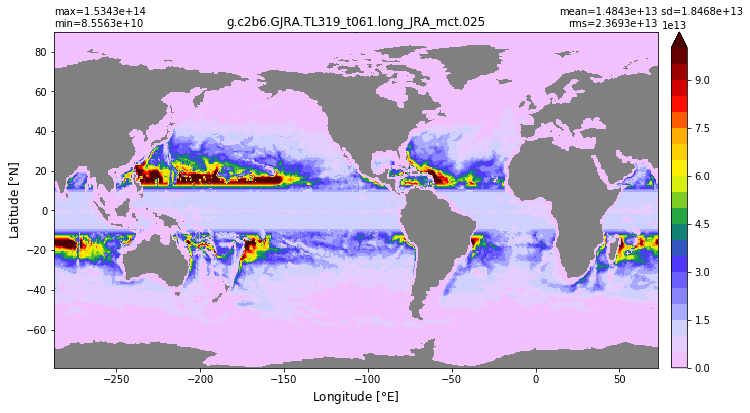

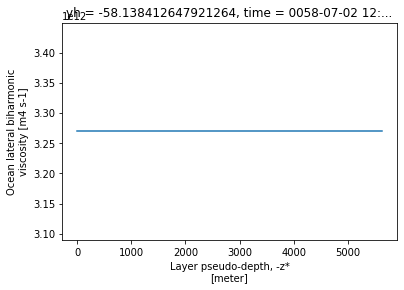

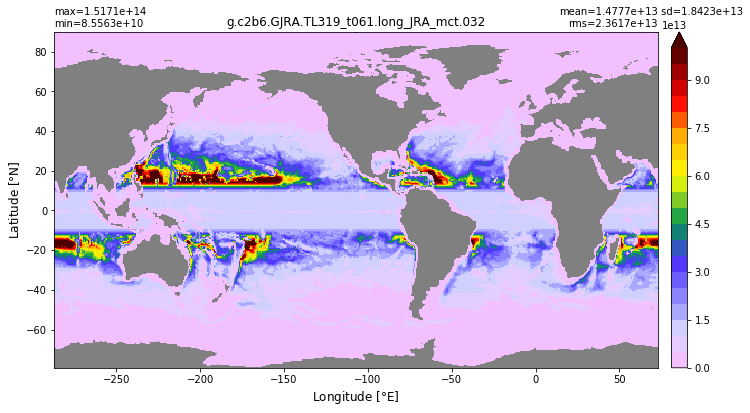

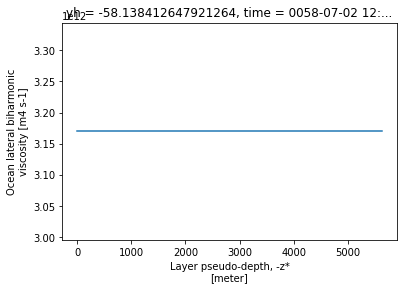

In [45]:
# Biharmonic
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0058.nc')
  xyplot(np.ma.masked_invalid(ds[variables[2]][0,0,:].values), grd.geolon, grd.geolat, area=grd.area_t, clim=(1.0e10,1.0e14), title=str(exps[exp]))
  f, ax = plt.subplots(1,1)
  ds[variables[2]][0,:,j,i].plot(ax=ax)

## Redi (KHTR)

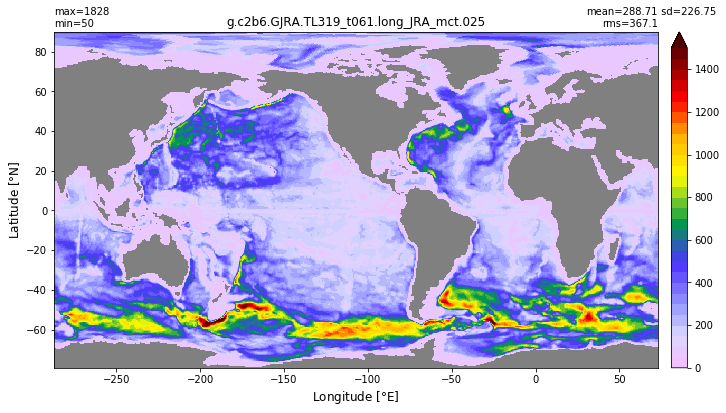

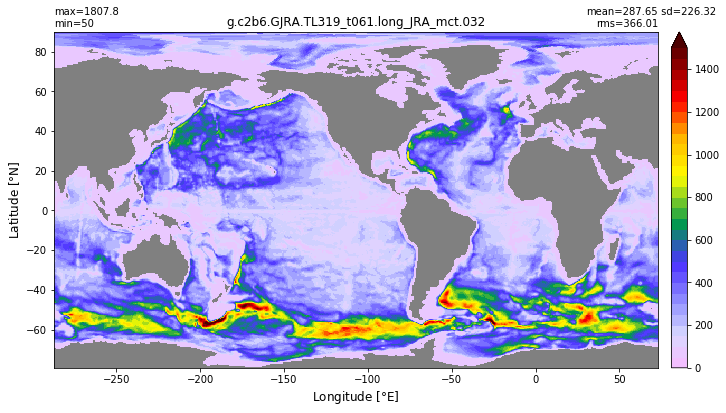

In [17]:
# KHTR (Redi)
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0058.nc')
  xyplot(np.ma.masked_invalid(ds[variables[3]][0,:].values), grd.geolon, grd.geolat, clim=(0, 1500), area=grd.area_t, title=str(exps[exp]))

# Sea Ice

## Ice concentration

<center> <font size="4">ANN mean</font></center>
<table>
    <tr>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/contour/con_ann_aice_cice.png'></td>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.032/contour/con_ann_aice_cice.png'></td>
    </tr> 
</table>

<center> <font size="4">JAS mean</font></center>
<table>
    <tr>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/contour/con_jas_aice_cice.png'></td>
        <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.032/contour/con_jas_aice_cice.png'></td>
    </tr> 
</table>

## Ice thickness

../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/ice/g.c2b6.GJRA.TL319_t061.long_JRA_mct.025.cice.h.0029-0058._ANN_climo.nc
../g.c2b6.GJRA.TL319_t061.long_JRA_mct.032/ice/g.c2b6.GJRA.TL319_t061.long_JRA_mct.032.cice.h.0029-0058._ANN_climo.nc


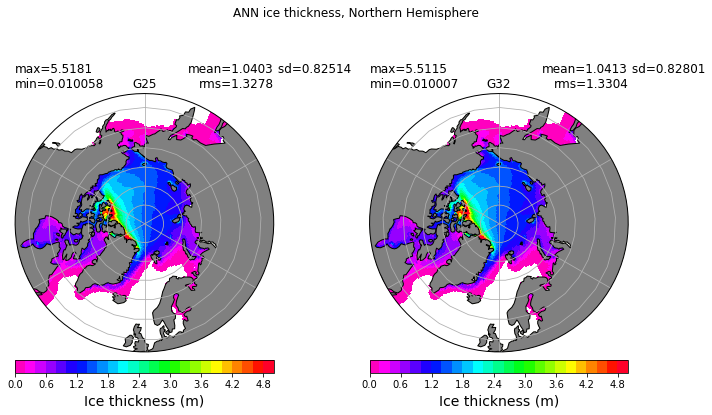

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6), subplot_kw={'projection': ccrs.NorthPolarStereo()})
plt.suptitle('ANN ice thickness, Northern Hemisphere')
for i in range(len(exps)):
  pfile = '../'+exps[i]+'/ice/'+exps[i]+'.cice.h.0029-0058._ANN_climo.nc'
  print(pfile)
  ds = get_data_sf(pfile)
  dummy = np.ma.masked_invalid(ds.hi.values[0,:])
  dummy = np.ma.masked_where(dummy < 0.01, dummy) 
  polarplot(dummy, grd, title=str(labels[i]), colormap=plt.cm.gist_rainbow_r, clim=(0,5), 
            axis=ax[i], proj='NP', clabel='Ice thickness (m)')

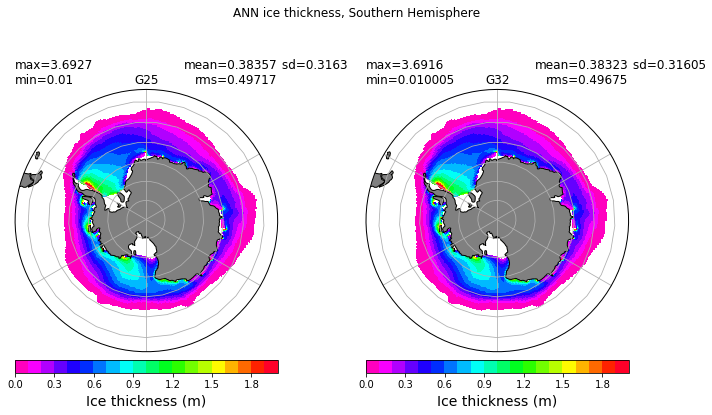

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6), subplot_kw={'projection': ccrs.SouthPolarStereo()})
plt.suptitle('ANN ice thickness, Southern Hemisphere')
for i in range(len(exps)):
  ds = get_data_sf('../'+exps[i]+'/ice/'+exps[i]+'.cice.h.0029-0058._ANN_climo.nc')
  dummy = np.ma.masked_invalid(ds.hi.values[0,:])
  dummy = np.ma.masked_where(dummy < 0.01, dummy) 
  polarplot(dummy, grd, title=str(labels[i]), colormap=plt.cm.gist_rainbow_r, clim=(0,2), 
            axis=ax[i], proj='SP', clabel='Ice thickness (m)')

## Sea ice extent climatology

<center> <font size="4">NH</font></center>
<table>
    <tr>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/line/clim_mo_NH.png'></td>
        <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.032/line/clim_mo_NH.png'></td>
    </tr> 
</table>

<center> <font size="4">SH</font></center>
<table>
    <tr>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/line/clim_mo_SH.png'></td>
        <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.032/line/clim_mo_SH.png'></td>
    </tr> 
</table>

## Time series

The code below generates many time series. Still work in progress...

In [31]:
#plt.suptitle('ANN ice thickness, Southern Hemisphere')
#ds = get_data_sf('../'+exps[1]+'/ice/model_vs_obs.29_58/ice_vol_bmom.e20.BMOM.f09_t061.long_run_mct.010_28-58.nc')
#fig, ax = plt.subplots(nrows=len(ds.variables)-1, ncols=1, figsize=(10,40), sharex=True)
#j=0
#for var in ds.variables:
#  if var != 'time':
#    for i in range(len(exps)):   
#      ds = get_data_sf('../'+exps[i]+'/ice/model_vs_obs.29_58/ice_vol_'+exps[i]+'_28-58.nc')
#      ds[var].plot(ax=ax[j])
#    ax[j].set_ylabel(ds[var].name)
#    j+=1   

<center> <font size="4">Sea ice extent time-series NH</font></center>
<table>
    <tr>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/line/line_mo_NH.png'></td>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.032/line/line_mo_NH.png'></td>
    </tr> 
</table>

<center> <font size="4">Sea ice extent time-series SH</font></center>
<table>
    <tr>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/line/line_mo_SH.png'></td>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.032/line/line_mo_SH.png'></td>
    </tr>
</table>